# Spotify Playlist Prediction (ML)

## _Project Overview_

Over the years, there has been a transition on how music lovers access music due to digitalization in the industry. Different mediums have been use to record music trailing back to vinyl records, cassettes, CDs, etc. Now with streaming platforms/apps as the primary model for streaming music, understanding our musical preferences becomes possible with the data at hand.

Therefore as a music ethusiast that regularly listens to many genres from different eras, two distinct playlists were curated on whether the songs were liked or disliked. The goal would be to identify key features through exploratory analysis and develop a model to predict and classify the songs relative to their target playlist. The pool of songs used for this analysis were sourced from recommended playlists of friends and extracted using the Spotify API.

## _Import Packages_

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

### _Spotify API Access_

In [2]:
# both credientals/IDs can be requested from Spotify, but are hidden for confidentiality
My_Client_ID = mc_id
My_Client_Secret_ID = mcs_id

User = "jokonkwo"

client_credentials_manager = SpotifyClientCredentials(mc_id, mcs_id)

spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

###  *Added Functions*

In [3]:
#show all columns in .head()
pd.set_option('display.max_columns', None)

#rename columns
def rename_feat(dataframe, feature, new):
    dataframe = dataframe.rename(columns= {feature:new})
    return dataframe;

#get all songs in playlist (>100 limit)
def get_playlist_tracks(username,playlist_id):
    results = spotify.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = spotify.next(results)
        tracks.extend(results['items'])
    return tracks

#one-hot encoding
def onehot(dataframe, feature):
    dataframe = pd.get_dummies(dataframe, columns=[feature])
    return dataframe;

### _Check/Display Playlist from User Account_

In [4]:
#GET USER PLAYLISTS spotify.search(playlist, type="playlist")

ALL_playlists = spotify.user_playlists("jokonkwo")

#CHECK PLAYLISTS BY name, track total, playlist id
playlists = ALL_playlists['items']
jokonkwo_playlists = []
for playlist in playlists:
    jokonkwo_playlists.append(("{0:30} {1:^30} {2}".format(playlist["name"], playlist["tracks"]["total"], playlist["id"])))

### *Extract Tracks/Audio Features from Playlists*

In [5]:
#Define playlist dictionaries
YES_playlist = spotify.playlist('1bTZhaRsnZCsYcUxYMrNnh')
NO_playlist = spotify.playlist('1mYn9MDrSeGKa1wlI3uHTL')

#Extract track dictionary from playlists
YES_songs = get_playlist_tracks('jokonkwo', '1bTZhaRsnZCsYcUxYMrNnh')
NO_songs = get_playlist_tracks('jokonkwo', '1mYn9MDrSeGKa1wlI3uHTL')

#Create lists containing [track name, track_id, artist name, artist_id]
Yes_list = []
for yes in YES_songs:
    Yes_list.append((yes['track']['name'], yes['track']['id'], yes['track']['artists'][0]['name'], yes['track']['artists'][0]['id']))

No_list = []
for no in NO_songs:
    No_list.append((no['track']['name'], no['track']['id'], no['track']['artists'][0]['name'], no['track']['artists'][0]['id']))

            #Note: get_playlist_tracks() allows an accumulation of tracks to be extracted over the set limit of 100 tracks*
            #Note: Important to understand/practice dictionary comprehension to access select key/values*

#Convert lists into dataframes
Yes_list1 = pd.DataFrame(Yes_list)
No_list1 = pd.DataFrame(No_list)

#Rename columns
Yes_list2 = Yes_list1.rename(columns= {0: 'song', 1: 'song_id', 2: 'artist', 3: 'artist_id'})
No_list2 = No_list1.rename(columns= {0: 'song', 1: 'song_id', 2: 'artist', 3: 'artist_id'})

            #Note: Didn't use rename_feat() due to function only renaming one column at a time*

#Extract all song_ids to a list
yes_song_ids = Yes_list2['song_id'].tolist()
no_song_ids = No_list2['song_id'].tolist()

            #Note: tolist() returns dataframe column into a list*

#Access to audio features per track via song_id
spotify.audio_features(yes_song_ids[0])[0]

            #Note: extra [0] allows access dictionary that is enclosed within a list*

#Extract audio features via list of song_id
yes_audio_features = []
for i in yes_song_ids:
    yes_audio_features.append(spotify.audio_features(i)[0])
    
no_audio_features = []
for i in no_song_ids:
    no_audio_features.append(spotify.audio_features(i)[0])

### *Data Transformation*

In [6]:
#Convert audio features into dataframe
df_yes_audio_features = pd.DataFrame(yes_audio_features)
df_no_audio_features = pd.DataFrame(no_audio_features)

#Rename audio features 'id' to 'song_id' for df.merge
df_yes_audio_features1 = df_yes_audio_features.rename(columns= {'id': 'song_id'})
df_no_audio_features1 = df_no_audio_features.rename(columns= {'id': 'song_id'})

#Outer merge of both dataframes (songs info and audio features) based on 'song_id'
df_yes = Yes_list2.merge(df_yes_audio_features1, how='outer', on='song_id')
df_no = No_list2.merge(df_no_audio_features1, how='outer', on='song_id')

#Drop unnecessary features/columns (for now)
df_yes1 = df_yes.drop(["analysis_url", "track_href", "type", "uri"], axis=1)
df_no1 = df_no.drop(["analysis_url", "track_href", "type", "uri"], axis=1)

#One-Hot Encode 'Key' feature - represents song key by #
df_yes1 = onehot(df_yes1, 'key')
df_no1 = onehot(df_no1, 'key')


#Add Target Feature
df_yes1['Liked'] = 1
df_no1['Liked'] = 0

            #df_yes1.shape

#Combine both yes/no dataframes
df_all = pd.concat([df_yes1, df_no1], ignore_index=True)

            #df_all.shape
            #Note - pd.concat() returns new dataframe by combining rows with the expectation of features being identical on both dataframes*
            #Note - ignore_index when TRUE ignores the initial index of respective dataframes from being carried over, start anew*
            #Note - .concat() axis = 0 for rows, axis = 1 for columns

In [7]:
df_all.head()

,song,song_id,artist,artist_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,Liked
0,PULL UP,7pI31mg1XsAPJCB6gQJSxK,ABRA,3ZJxEmjYZd5VOqZ8o3aXiL,0.0158,0.788,178907,0.491,0.802000,0.0824,-8.537,1,0.0516,119.992,4,0.724,1,0,0,0,0,0,0,0,0,0,0,0,1
1,Spaced Out,4y3l1Qk130C1ebtgIGxltq,Young Nudy,5yPzzu25VzEk8qrGTLIrE1,0.0493,0.704,189554,0.594,0.000053,0.1320,-6.966,1,0.2110,78.585,4,0.296,0,0,1,0,0,0,0,0,0,0,0,0,1
2,Riot!,6cmt9CRoK0KGcNg9Tpje53,Earl Sweatshirt,3A5tHz1SfngyOZM2gItYKu,0.8340,0.489,66133,0.624,0.347000,0.3250,-1.916,0,0.0344,167.108,4,0.574,0,0,0,0,1,0,0,0,0,0,0,0,1
3,i want war (BUT I NEED PEACE),5Dx8iEsMuNrf7aF9TMV0Xe,Kali Uchis,1U1el3k54VvEUzo3ybLPlM,0.7150,0.621,159400,0.461,0.001110,0.0929,-13.047,0,0.0735,88.034,4,0.122,1,0,0,0,0,0,0,0,0,0,0,0,1
4,Egyptian Luvr,78DC9wd9Qrikw4jWllFAvM,Rejjie Snow,3lLHpTOJ11tWiUNGYN14gt,0.0553,0.834,256613,0.591,0.000000,0.0740,-7.543,0,0.3050,104.944,4,0.900,0,0,0,0,0,0,0,0,0,0,1,0,1


### *Exploratory Data Analysis (EDA)*

#### *Popularity Influence*

*Note: Possibility track and/or artist popularity may have an significant affect on target feature. Therefore extracted values to dataframe via Spotify API to explore*

In [8]:
#Append track/artist name, track popularity into a list of lists
tracks_popularity = []
for track in range(len(df_all)):
    tracks_popularity.append([df_all['song'][track], spotify.track(df_all["song_id"][track])["popularity"]])

#Append track/artist name, artist popularity into a list of lists    
artists_popularity = []
for track in range(len(df_all)):
    artists_popularity.append([df_all['artist'][track], spotify.artist(df_all["artist_id"][track])["popularity"]])
    
            #tracks_popularity
            #artists_popularity

#Extract track/artist popularity from list into a new list
tracks_popularity1 = []
for tpop in range(len(tracks_popularity)):
    tracks_popularity1.append((tracks_popularity[tpop][1]))

artists_popularity1 = []
for apop in range(len(artists_popularity)):
    artists_popularity1.append((artists_popularity[apop][1]))
    
            #track_popularity1
            #artist_popularity1
    
#Convert list into array in order to apply as a new dataframe feature
tp1 = np.asarray(tracks_popularity1)
ap1 = np.asarray(artists_popularity1)
df_all['track_popularity'] = tp1
df_all['artist_popularity'] = ap1

            #df_all

*Note: Created 'artist/track popularity' list for reference of artist/track name AND popularity values associated. Then extracted JUST popularity values for *dataframe feature** 

#### *Year Influence*

*Note: Possibility release year of the track may have an significant affect on target feature. Therefore extracted values to dataframe via Spotify API to explore*

In [9]:
#Append track/artist name, release year into a list of lists
release_year = []
for track in range(len(df_all)):
    release_year.append([df_all['song'][track], spotify.track(df_all['song_id'][track])['album']['release_date']])

    #release_date = 'YEAR-MONTH-DAY' per Spotify API
    
#Extract track/artist name, release year from list into a new list
release_year1 = []
for year in range(len(release_year)):
    release_year1.append((release_year[year][1]))
    
            #release_year

#Extract just year by splicing string (2020-01-02)
release_year2 = []
for year in range(len(release_year1)):
    release_year2.append((release_year1[year][0:4]))   

            #release_year2 

#Convert list into array in order to apply as a new dataframe feature
ry2 = np.asarray(release_year2)
df_all['release_year'] = ry2
df_all['release_year'] = pd.to_numeric(df_all['release_year'])

            #df_all.head()

#Create feature for song age     
df_all['song_age'] = 2020 - df_all['release_year']

#Create feature for decades year
df_all['decades'] = pd.cut(df_all['release_year'], [1960, 1969, 1979, 1989, 1999, 2009, 2019, 2021], labels = ['1960','1970', '1980', '1990', '2000', '2010', '2020'])
df_all["decade"] = df_all["decades"]
df_all = pd.get_dummies(df_all, columns=['decades'])
df_all['decade'] = pd.to_numeric(df_all['decade'])

#One-Hot Encode 'Time Signature' feature - represents time signature by #
df_all = onehot(df_all, 'time_signature')

#df_all.loc[df_all['Liked'] == 1 & df_all['song_age'] > 20, ]
#df_all.loc[df_all['Liked']==1, df_all["song_age"] > 20]



        #df_all.head()

### *Statistical Summary*

In [10]:
df_all.describe() #all songs

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,Liked,track_popularity,artist_popularity,release_year,song_age,decade,decades_1960,decades_1970,decades_1980,decades_1990,decades_2000,decades_2010,decades_2020,time_signature_1,time_signature_3,time_signature_4,time_signature_5
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.00000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.329117,0.665923,224186.813333,0.555721,0.069924,0.161163,-8.480390,0.490000,0.136079,115.081533,0.492244,0.130000,0.106667,0.083333,0.030000,0.056667,0.103333,0.086667,0.100000,0.053333,0.076667,0.083333,0.09000,0.533333,46.613333,66.350000,2014.253333,5.746667,2010.100000,0.006667,0.063333,0.010000,0.020000,0.013333,0.506667,0.380000,0.016667,0.026667,0.953333,0.003333
std,0.274953,0.148053,82564.697085,0.165310,0.197933,0.117700,3.058306,0.500735,0.123035,27.348425,0.214135,0.336865,0.309205,0.276847,0.170872,0.231591,0.304902,0.281816,0.300501,0.225073,0.266506,0.276847,0.28666,0.499721,19.180288,16.594339,12.361980,12.361980,13.225217,0.081513,0.243968,0.099665,0.140234,0.114889,0.500791,0.486197,0.128233,0.161376,0.211276,0.057735
min,0.000025,0.156000,48423.000000,0.066800,0.000000,0.031000,-21.504000,0.000000,0.023500,63.588000,0.036300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,21.000000,1967.000000,0.000000,1960.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.082575,0.557500,171917.000000,0.439000,0.000000,0.095200,-9.980750,0.000000,0.046500,94.003500,0.336000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,37.750000,55.750000,2017.000000,0.000000,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.256000,0.677500,210586.000000,0.562500,0.000025,0.116000,-8.157000,0.000000,0.076550,111.482000,0.505500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,49.000000,68.000000,2018.000000,2.000000,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.536000,0.777500,246194.750000,0.663250,0.003282,0.182500,-6.513000,1.000000,0.203250,134.914750,0.634000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,61.000000,79.250000,2020.000000,3.000000,2020.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,0.985000,0.964000,636733.000000,0.945000,0.917000,0.795000,-1.916000,1.000000,0.641000,191.891000,0.962000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,79.000000,98.000000,2020.000000,53.000000,2020.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df_all[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness']].corr()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness
acousticness,1.000000,-0.203603,-0.512514,0.201684,-0.046146,-0.415519,0.049777
danceability,-0.203603,1.000000,-0.047877,-0.163921,-0.059314,0.173995,0.164501
energy,-0.512514,-0.047877,1.000000,-0.203045,0.204526,0.636712,0.024333
instrumentalness,0.201684,-0.163921,-0.203045,1.000000,-0.041025,-0.415541,-0.225712
liveness,-0.046146,-0.059314,0.204526,-0.041025,1.000000,0.119823,0.004297
loudness,-0.415519,0.173995,0.636712,-0.415541,0.119823,1.000000,0.063079
speechiness,0.049777,0.164501,0.024333,-0.225712,0.004297,0.063079,1.000000


## *Data Visualization*

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### *Identify Trends by Feature/Target Relationship*

E:\Python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
E:\Python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
E:\Python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel densi

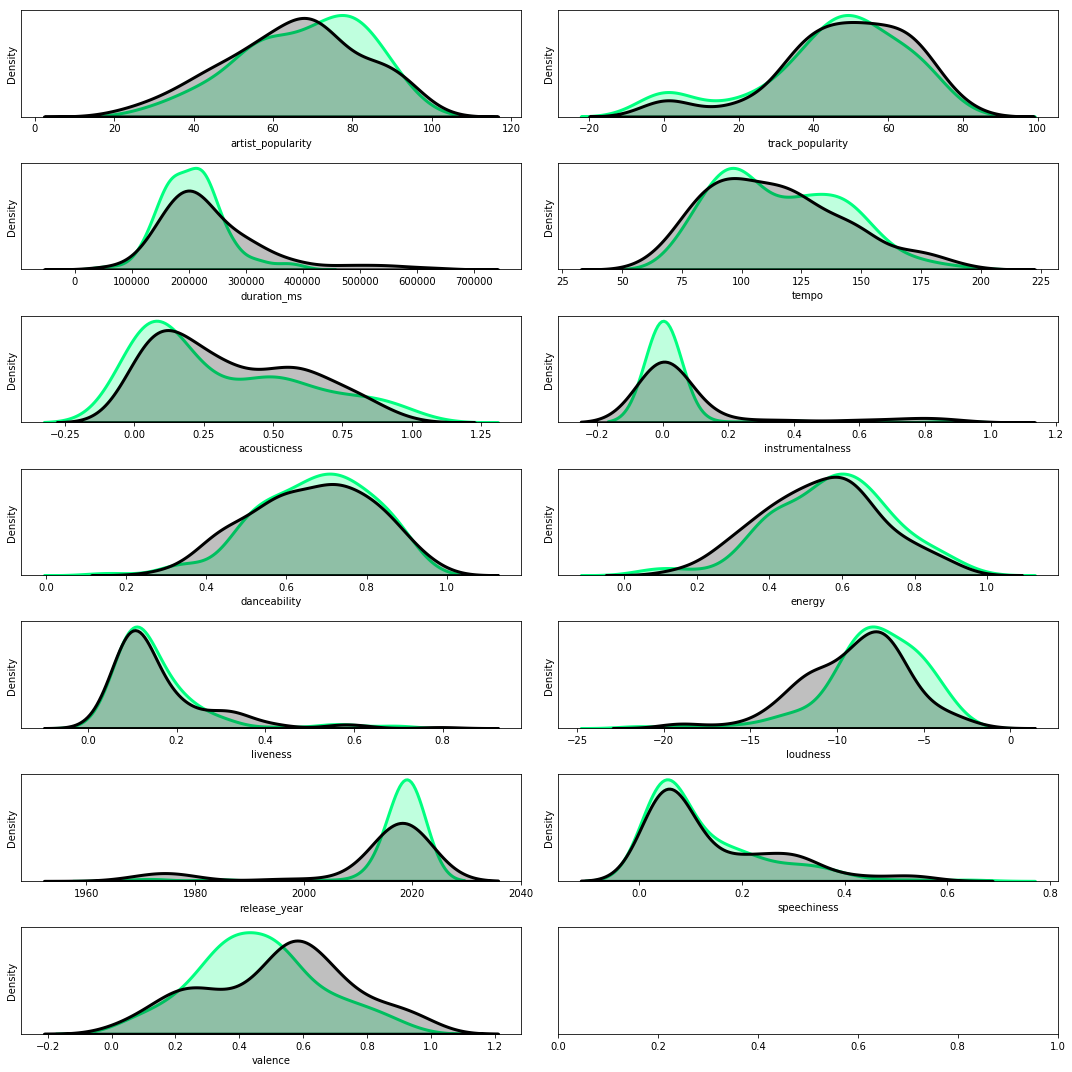

In [13]:
viz_feats = ['artist_popularity', 'track_popularity', 'duration_ms', 'tempo', 'acousticness', 'instrumentalness', 'danceability', 'energy']
# Set up the matplotlib figure
f, axes = plt.subplots(7, 2, figsize=(15, 15), sharex=False)

# Artist Popularity
sns.distplot(df_all.loc[(df_all['Liked']==0), "artist_popularity"], color = "springgreen", hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Not Liked", ax=axes[0, 0])
sns.distplot(df_all.loc[(df_all['Liked']==1), "artist_popularity"], color = "black", hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Liked", ax=axes[0, 0])

# Track Popularity
sns.distplot(df_all.loc[(df_all['Liked']==0), "track_popularity"], color = "springgreen", hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Not Liked", ax=axes[0, 1])
sns.distplot(df_all.loc[(df_all['Liked']==1), "track_popularity"], color = "black", hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Liked", ax=axes[0, 1])

# Song Duration
sns.distplot(df_all.loc[(df_all['Liked']==0), "duration_ms"], color = "springgreen", hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Not Liked", ax=axes[1, 0])
sns.distplot(df_all.loc[(df_all['Liked']==1), "duration_ms"], color = "black", hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Liked", ax=axes[1, 0])

# Tempo
sns.distplot(df_all.loc[(df_all['Liked']==0), "tempo"], color = "springgreen", hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Not Liked",  ax=axes[1, 1])
sns.distplot(df_all.loc[(df_all['Liked']==1), "tempo"], color = "black", hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Liked",  ax=axes[1, 1])
# Acousticness
sns.distplot(df_all.loc[(df_all['Liked']==0), "acousticness"], color = "springgreen", hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Not Liked", ax=axes[2, 0])
sns.distplot(df_all.loc[(df_all['Liked']==1), "acousticness"], color = "black", hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Liked", ax=axes[2, 0])

# Instrumentalness
sns.distplot(df_all.loc[(df_all['Liked']==0), "instrumentalness"], color = "springgreen", hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Not Liked", ax=axes[2, 1])
sns.distplot(df_all.loc[(df_all['Liked']==1), "instrumentalness"], color = "black", hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Liked", ax=axes[2, 1])

# Danceability
sns.distplot(df_all.loc[(df_all['Liked']==0), "danceability"], color = "springgreen", hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Not Liked", ax=axes[3, 0])
sns.distplot(df_all.loc[(df_all['Liked']==1), "danceability"], color = "black", hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Liked", ax=axes[3, 0])

# Energy
sns.distplot(df_all.loc[(df_all['Liked']==0), "energy"], color = "springgreen", hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Not Liked", ax=axes[3, 1])
sns.distplot(df_all.loc[(df_all['Liked']==1), "energy"], color = "black", hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Liked", ax=axes[3, 1])

# Liveness
sns.distplot(df_all.loc[(df_all['Liked']==0), "liveness"], color = "springgreen", hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Not Liked", ax=axes[4, 0])
sns.distplot(df_all.loc[(df_all['Liked']==1), "liveness"], color = "black", hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Liked", ax=axes[4, 0])

# Loudness
sns.distplot(df_all.loc[(df_all['Liked']==0), "loudness"], color = "springgreen", hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Not Liked", ax=axes[4, 1])
sns.distplot(df_all.loc[(df_all['Liked']==1), "loudness"], color = "black", hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Liked", ax=axes[4, 1])

# Release Year
sns.distplot(df_all.loc[(df_all['Liked']==0), "release_year"], color = "springgreen", hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Not Liked", ax=axes[5, 0])
sns.distplot(df_all.loc[(df_all['Liked']==1), "release_year"], color = "black", hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Liked", ax=axes[5, 0])

# Speechiness
sns.distplot(df_all.loc[(df_all['Liked']==0), "speechiness"], color = "springgreen", hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Not Liked", ax=axes[5, 1])
sns.distplot(df_all.loc[(df_all['Liked']==1), "speechiness"], color = "black", hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Liked", ax=axes[5, 1])

# Valence
sns.distplot(df_all.loc[(df_all['Liked']==0), "valence"], color = "springgreen", hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Not Liked", ax=axes[6, 0])
sns.distplot(df_all.loc[(df_all['Liked']==1), "valence"], color = "black", hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "Liked", ax=axes[6, 0])

plt.setp(axes, yticks=[])
plt.tight_layout()

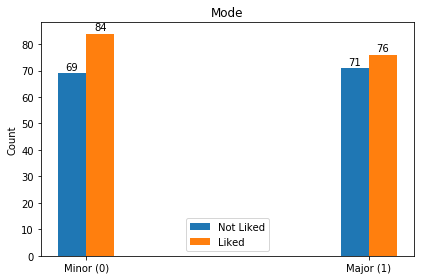

In [14]:
# Mode Count by Liked
not_liked_mode = []
for x in range(len(df_all['Liked'].value_counts())):
    not_liked_mode.append(df_all.loc[(df_all['Liked']==0), 'mode'].value_counts()[x])

liked_mode = []
for x in range(len(df_all['Liked'].value_counts())):
    liked_mode.append(df_all.loc[(df_all['Liked']==1), 'mode'].value_counts()[x])
    
# Plot Code
labels = ['Minor (0)', 'Major (1)']

x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, not_liked_mode, width, label='Not Liked')
rects2 = ax.bar(x + width/2, liked_mode, width, label='Liked')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Mode')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    # Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### *Decade Analysis*

In [15]:
decade_analysis = df_all[['decade', 'Liked']].groupby(['decade']).mean().sort_values(by='decade', ascending=False)
decade_analysis['count'] = df_all['decade'].value_counts().sort_index(ascending=False)
decade_analysis

,Liked,count
decade,,
2020,0.377193,114
2010,0.598684,152
2000,0.750000,4
1990,0.666667,6
1980,0.333333,3
1970,0.894737,19
1960,0.500000,2


### *T-Test Example*

In [16]:
#Extract values for statistical testing

apop_liked = df_all.loc[(df_all['Liked']==1), "artist_popularity"]
apop_disliked = df_all.loc[(df_all['Liked']==0), "artist_popularity"]

#Execute t-test for significance
stats.ttest_ind(apop_liked, apop_disliked)

Ttest_indResult(statistic=-1.4532692554668265, pvalue=0.1472012432222087)

**_NOT SIGNIFICANT_** (P-value > .05)

In [17]:
#Extract values for statistical testing

tpop_liked = df_all.loc[(df_all['Liked']==1), "track_popularity"]
tpop_disliked = df_all.loc[(df_all['Liked']==0), "track_popularity"]

#Execute t-test for significance
stats.ttest_ind(tpop_liked, tpop_disliked)

Ttest_indResult(statistic=1.516936236652005, pvalue=0.1303428555870584)

**_NOT SIGNIFICANT_** (P-value > .05)

In [18]:
#Extract values for statistical testing

duration_liked = df_all.loc[(df_all['Liked']==1), "duration_ms"]
duration_disliked = df_all.loc[(df_all['Liked']==0), "duration_ms"]

#Execute t-test for significance
stats.ttest_ind(duration_liked, duration_disliked)

Ttest_indResult(statistic=3.7625159616316086, pvalue=0.00020253047888847862)

**_SIGNIFICANT_** (P-value > .05)

# *Model Preparation*

### *Drop columns*

In [19]:
df_final = df_all.drop(["song", "song_id", "artist", "artist_id", "release_year", "decade"], axis=1)
#df_final1 = df_all.drop(["song", "song_id", "artist", "artist_id"], axis=1)
#df_all = df_all.drop(["decade"], axis=1)

#Target feature last

feature_order = [feature for feature in list(df_final.columns) if feature not in ["Liked"]] + ["Liked"]
df_final = df_final.loc[:, feature_order]
df_final.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,track_popularity,artist_popularity,song_age,decades_1960,decades_1970,decades_1980,decades_1990,decades_2000,decades_2010,decades_2020,time_signature_1,time_signature_3,time_signature_4,time_signature_5,Liked
0,0.0158,0.788,178907,0.491,0.802000,0.0824,-8.537,1,0.0516,119.992,0.724,1,0,0,0,0,0,0,0,0,0,0,0,0,61,4,0,0,0,0,0,1,0,0,0,1,0,1
1,0.0493,0.704,189554,0.594,0.000053,0.1320,-6.966,1,0.2110,78.585,0.296,0,0,1,0,0,0,0,0,0,0,0,0,47,74,4,0,0,0,0,0,1,0,0,0,1,0,1
2,0.8340,0.489,66133,0.624,0.347000,0.3250,-1.916,0,0.0344,167.108,0.574,0,0,0,0,1,0,0,0,0,0,0,0,66,71,2,0,0,0,0,0,1,0,0,0,1,0,1
3,0.7150,0.621,159400,0.461,0.001110,0.0929,-13.047,0,0.0735,88.034,0.122,1,0,0,0,0,0,0,0,0,0,0,0,55,85,0,0,0,0,0,0,0,1,0,0,1,0,1
4,0.0553,0.834,256613,0.591,0.000000,0.0740,-7.543,0,0.3050,104.944,0.900,0,0,0,0,0,0,0,0,0,0,1,0,56,68,2,0,0,0,0,0,1,0,0,0,1,0,1


### *Separate the data into X (features) and Y (target)*

In [20]:
#Feature values into X
X = df_final.iloc[:,:-1].values

#Target values into Y
Y = df_final.iloc[:,-1].values

### *Split the data into train and test sets*

In [21]:
#Split data into train and test sets, adjusted hyperparameters if necessary
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    random_state=0, 
                                                    test_size=0.3)
N = Y_test.size

# standardize features using scikit-learn
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# *Model Selection*

### *Classification Algorithms*

In [22]:
# Instantiate the various algorithms

# Logistic Regression

# --- Key Parameters ---
# C: the regularization strength (smaller values for greater regularization); default is 1.0
# l2 is the default penalty used for regularizartion;
#         l1 may be used for feature selection
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=1)

# Support Vector Machine

# --- Key Parameters ---
# C: how much penalty there is for misclassification (larger values for greater penalty); default is 1.0
# kernel: specifies the kernel type to be used (‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’); default is 'rbf'
# gamma: the coefficient for non-linear kernels (default is appox. 1/n_features)
from sklearn.svm import SVC
svm = SVC(C=1, kernel="rbf", gamma=.1)

# Random Forest (ensemble of Decision Trees)

# --- Key Parameters ---
# n_estimators: the number of trees in the forest; default is 10
# max_depth: the depth of the tree; defualt is None, full expansion
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10)

# k-Nearest Neighbor

# --- Key Parameters ---
# n_neighbors: number of neighbors to use; default is 5
# weights: weight function used; default is 'uniform'
        # 'uniform' means all points are weighted equally;
        # 'distance' means closer points have greater influence
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, roc_auc_score 

E:\Python\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### Logistic Regression


LOGISTIC REGRESSION
Misclassified 42 out of 90
Accuracy: 0.53
training set score: 0.747619
test set score: 0.533333


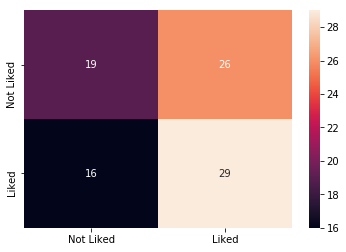

In [23]:
log_reg.fit(X_train_std, Y_train)
Y_pred = log_reg.predict(X_test_std)

print ("\nLOGISTIC REGRESSION")
print ("Misclassified {} out of {}".format( (Y_test != Y_pred).sum(), N))
print("Accuracy: %.2f" % accuracy_score(Y_test, Y_pred))
print("training set score: %f" % log_reg.score(X_train_std, Y_train))
print("test set score: %f" % log_reg.score(X_test_std, Y_test))

# CONFUSION MATRIX
plt.ylabel("Real value")
plt.xlabel("Predicted value")
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['Not Liked', 'Liked'], yticklabels=['Not Liked', 'Liked'])

#### Support Vector Machine


SUPPORT VECTOR MACHINE
Misclassified 41 out of 90
Accuracy: 0.54
training set score: 0.942857
test set score: 0.544444


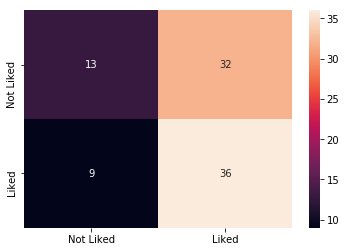

In [24]:
svm.fit(X_train_std, Y_train)
Y_pred = svm.predict(X_test_std)

print ("\nSUPPORT VECTOR MACHINE")
print ("Misclassified {} out of {}".format( (Y_test != Y_pred).sum(), N))
print("Accuracy: %.2f" % accuracy_score(Y_test, Y_pred))
print("training set score: %f" % svm.score(X_train_std, Y_train))
print("test set score: %f" % svm.score(X_test_std, Y_test))

# CONFUSION MATRIX
plt.ylabel("Real value")
plt.xlabel("Predicted value")
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['Not Liked', 'Liked'], yticklabels=['Not Liked', 'Liked'])

#### Random Forest


RANDOM FOREST
Misclassified 37 out of 90
Accuracy: 0.59
training set score: 0.980952
test set score: 0.588889


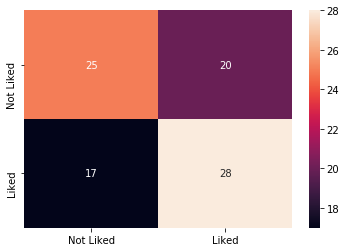

In [25]:
forest.fit(X_train_std, Y_train)
Y_pred = forest.predict(X_test_std)

print ("\nRANDOM FOREST")
print ("Misclassified {} out of {}".format( (Y_test != Y_pred).sum(), N))
print("Accuracy: %.2f" % accuracy_score(Y_test, Y_pred))
print("training set score: %f" % forest.score(X_train_std, Y_train))
print("test set score: %f" % forest.score(X_test_std, Y_test))

# CONFUSION MATRIX
plt.ylabel("Real value")
plt.xlabel("Predicted value")
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['Not Liked', 'Liked'], yticklabels=['Not Liked', 'Liked'])

#### K-Nearnest Neighbors


RANDOM FOREST
Misclassified 46 out of 90
Accuracy: 0.49
training set score: 0.747619
test set score: 0.488889


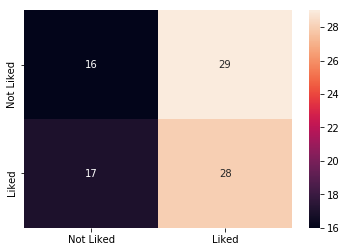

In [26]:
knn.fit(X_train_std, Y_train)
Y_pred = knn.predict(X_test_std)

print ("\nRANDOM FOREST")
print ("Misclassified {} out of {}".format( (Y_test != Y_pred).sum(), N))
print("Accuracy: %.2f" % accuracy_score(Y_test, Y_pred))
print("training set score: %f" % knn.score(X_train_std, Y_train))
print("test set score: %f" % knn.score(X_test_std, Y_test))

# CONFUSION MATRIX
plt.ylabel("Real value")
plt.xlabel("Predicted value")
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['Not Liked', 'Liked'], yticklabels=['Not Liked', 'Liked'])

### *Cross Validation*

In [27]:
# 10-fold cross validation with a single algorithm

# scoring parameter: 'accuracy', 'precision', 'recall', ‘balanced_accuracy’

from sklearn.model_selection import cross_val_score
acc_scores = cross_val_score(log_reg, X_train_std, Y_train, scoring='accuracy', cv=10)
prec_scores = cross_val_score(log_reg, X_train_std, Y_train, scoring='precision', cv=10)
rec_scores = cross_val_score(log_reg, X_train_std, Y_train, scoring='recall', cv=10)

In [28]:
acc_scores, prec_scores, rec_scores

(array([0.72727273, 0.63636364, 0.54545455, 0.5       , 0.59090909,
        0.7       , 0.7       , 0.65      , 0.55      , 0.45      ]),
 array([0.75      , 0.66666667, 0.58333333, 0.54545455, 0.63636364,
        0.72727273, 0.77777778, 0.83333333, 0.58333333, 0.5       ]),
 array([0.75      , 0.66666667, 0.58333333, 0.5       , 0.58333333,
        0.72727273, 0.63636364, 0.45454545, 0.63636364, 0.63636364]))

In [29]:
acc_scores.mean(), prec_scores.mean(), rec_scores.mean()

(0.6050000000000001, 0.6603535353535354, 0.6174242424242424)

# Evaluating Multiple Models

In [30]:
# 10-fold cross validation with a list of algorithms

classifiers = [log_reg, svm, forest, knn]

acc_model_scores = []
prec_model_scores = []
rec_model_scores = []
for clf in classifiers:
    acc_model_scores.append(cross_val_score(clf, X_train_std, Y_train, scoring='accuracy', cv=10))
    prec_model_scores.append(cross_val_score(clf, X_train_std, Y_train, scoring='precision', cv=10))
    rec_model_scores.append(cross_val_score(clf, X_train_std, Y_train, scoring='recall', cv=10))
acc_model_scores

[array([0.72727273, 0.63636364, 0.54545455, 0.5       , 0.59090909,
        0.7       , 0.7       , 0.65      , 0.55      , 0.45      ]),
 array([0.59090909, 0.68181818, 0.77272727, 0.5       , 0.54545455,
        0.6       , 0.65      , 0.65      , 0.45      , 0.45      ]),
 array([0.5       , 0.68181818, 0.63636364, 0.68181818, 0.54545455,
        0.5       , 0.7       , 0.75      , 0.65      , 0.5       ]),
 array([0.5       , 0.68181818, 0.63636364, 0.54545455, 0.5       ,
        0.6       , 0.7       , 0.55      , 0.45      , 0.45      ])]

#### Accuracy

In [31]:
# use a DataFrame to view the cross validation results

acc_models_df = pd.DataFrame(acc_model_scores, columns=[1,2,3,4,5,6,7,8,9,10],
                               index=["LR", "SVM", "Forest", "KNN"])

prec_models_df = pd.DataFrame(prec_model_scores, columns=[1,2,3,4,5,6,7,8,9,10],
                               index=["LR", "SVM", "Forest", "KNN"])

rec_models_df = pd.DataFrame(rec_model_scores, columns=[1,2,3,4,5,6,7,8,9,10],
                               index=["LR", "SVM", "Forest", "KNN"])

acc_models_df["Mean"] = acc_models_df.mean(axis=1)
prec_models_df["Mean"] = acc_models_df.mean(axis=1)
rec_models_df["Mean"] = acc_models_df.mean(axis=1)

acc_models_df
#prec_models_df
#rec_models_df

,1,2,3,4,5,6,7,8,9,10,Mean
LR,0.727273,0.636364,0.545455,0.500000,0.590909,0.7,0.70,0.65,0.55,0.45,0.605000
SVM,0.590909,0.681818,0.772727,0.500000,0.545455,0.6,0.65,0.65,0.45,0.45,0.589091
Forest,0.500000,0.681818,0.636364,0.681818,0.545455,0.5,0.70,0.75,0.65,0.50,0.614545
KNN,0.500000,0.681818,0.636364,0.545455,0.500000,0.6,0.70,0.55,0.45,0.45,0.561364


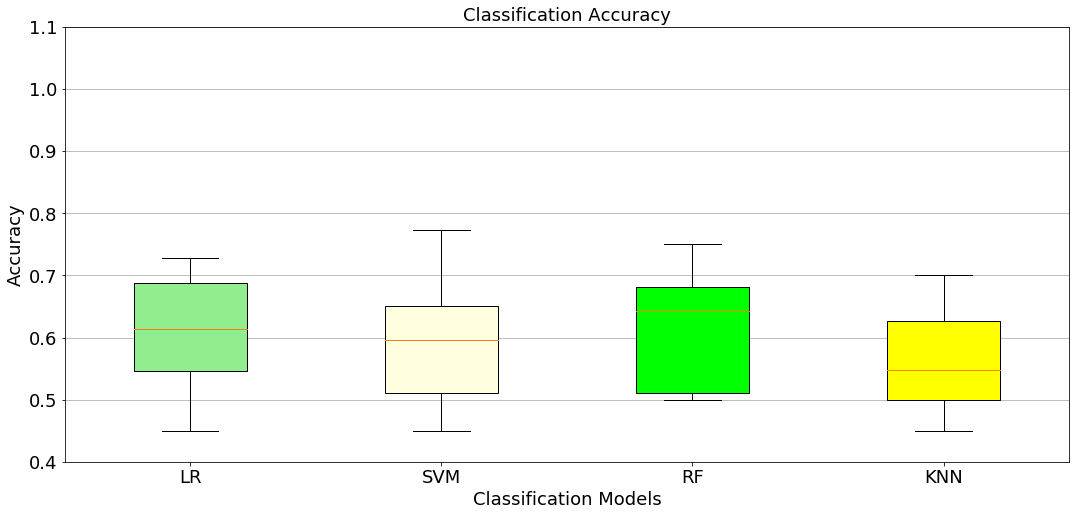

In [32]:
# BOXPLOT - visually comparing performance of the models

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))

# rectangular box plot
# place the cross-validated model_scores list from above
# into bplot_models here ------->
                           ##############
bplot_models = axes.boxplot(acc_model_scores, vert=True, patch_artist=True)
                           ##############
    
# fill with colors - Models
colors_d = ["lightgreen", "lightyellow", "lime", "yellow"]
for patch, color in zip(bplot_models['boxes'], colors_d):
    patch.set_facecolor(color)
    
    # adding axes labels
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(acc_model_scores))])
axes.set_xlabel('Classification Models', fontsize=18)
axes.set_ylabel('Accuracy', fontsize=18)
axes.set_ylim((.4, 1.1))
axes.set_title('Classification Accuracy', fontsize = 18)

# add x-tick labels
plt.setp(axes, xticks=[y+1 for y in range(len(acc_model_scores))],xticklabels=['LR', 'SVM', 'RF', 'KNN'])

# increase tick size
y_ticks = axes.get_yticklabels()
x_ticks = axes.get_xticklabels()

for x in x_ticks: 
    x.set_fontsize(18)       
for y in y_ticks:
    y.set_fontsize(18)

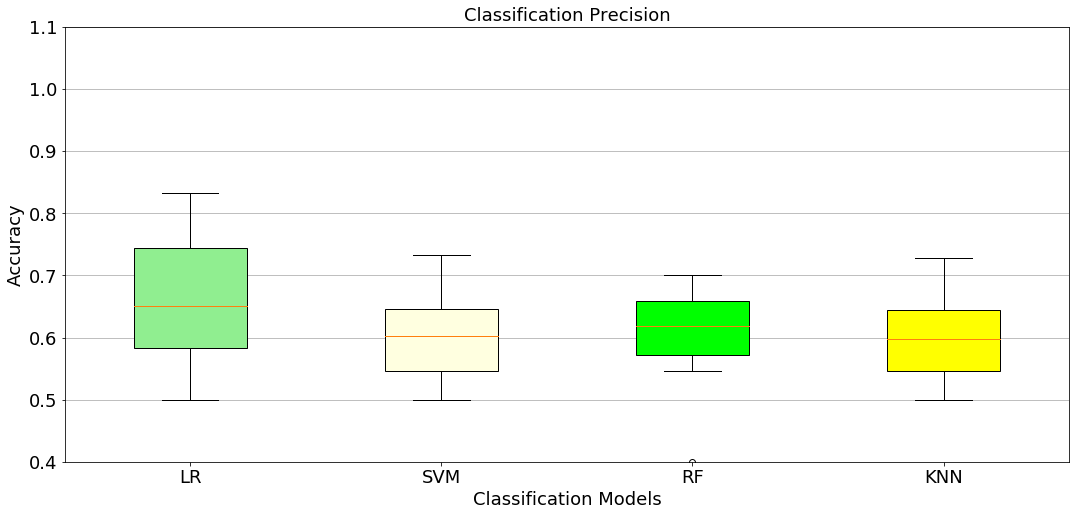

In [33]:
# BOXPLOT - visually comparing performance of the models

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))

# rectangular box plot
# place the cross-validated model_scores list from above
# into bplot_models here ------->
                           ##############
bplot_models = axes.boxplot(prec_model_scores, vert=True, patch_artist=True)
                           ##############
    
# fill with colors - Models
colors_d = ["lightgreen", "lightyellow", "lime", "yellow"]
for patch, color in zip(bplot_models['boxes'], colors_d):
    patch.set_facecolor(color)
    
    # adding axes labels
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(prec_model_scores))])
axes.set_xlabel('Classification Models', fontsize=18)
axes.set_ylabel('Accuracy', fontsize=18)
axes.set_ylim((.4, 1.1))
axes.set_title('Classification Precision', fontsize = 18)

# add x-tick labels
plt.setp(axes, xticks=[y+1 for y in range(len(prec_model_scores))],xticklabels=['LR', 'SVM', 'RF', 'KNN'])

# increase tick size
y_ticks = axes.get_yticklabels()
x_ticks = axes.get_xticklabels()

for x in x_ticks: 
    x.set_fontsize(18)       
for y in y_ticks:
    y.set_fontsize(18)

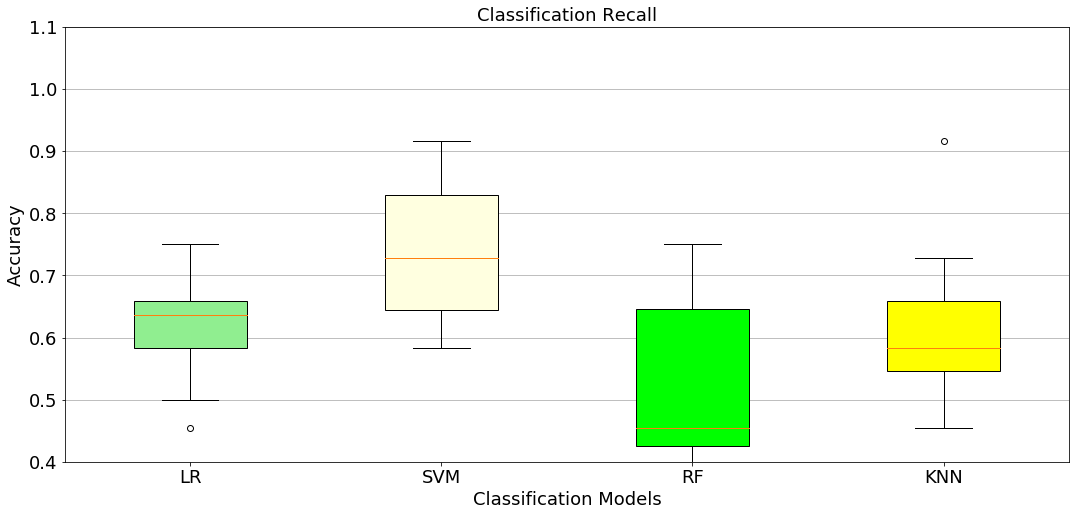

In [35]:
# BOXPLOT - visually comparing performance of the models

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))

# rectangular box plot
# place the cross-validated model_scores list from above
# into bplot_models here ------->
                           ##############
bplot_models = axes.boxplot(rec_model_scores, vert=True, patch_artist=True)
                           ##############
    
# fill with colors - Models
colors_d = ["lightgreen", "lightyellow", "lime", "yellow"]
for patch, color in zip(bplot_models['boxes'], colors_d):
    patch.set_facecolor(color)
    
    # adding axes labels
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(rec_model_scores))])
axes.set_xlabel('Classification Models', fontsize=18)
axes.set_ylabel('Accuracy', fontsize=18)
axes.set_ylim((.4, 1.1))
axes.set_title('Classification Recall', fontsize = 18)

# add x-tick labels
plt.setp(axes, xticks=[y+1 for y in range(len(rec_model_scores))],xticklabels=['LR', 'SVM', 'RF', 'KNN'])

# increase tick size
y_ticks = axes.get_yticklabels()
x_ticks = axes.get_xticklabels()

for x in x_ticks: 
    x.set_fontsize(18)       
for y in y_ticks:
    y.set_fontsize(18)

---